# Machine Learning in Python - Group Project 1

**Due Friday, March 10th by 16.00 pm.**

Group 15: William Jones, Elliot Leishman, Tristan Pang and Aidan Garrity

## General Setup

In [1]:
# Add any additional libraries or submodules below

# Data libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")


# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


# sklearn modules that are necessary
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline

In [2]:
# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80
cmap = plt.get_cmap("tab10") # define colours
sns.set(rc={'figure.figsize': (14, 8)})

In [3]:
# Load data
data = pd.read_csv("the_office.csv")

## 1. Introduction


IMDb ratings give a valuable indicator on how popular episodes of television shows are with viewers. NBC Universal would like to understand what makes certain episodes of The Office more popular than others, so they can produce a special reunion episode with as high an IMDb rating as possible. 

This report uses data on The Office to build and validate a predictive model that captures the underlying relationship between episode features and IMDb rating, and advises on what NBC Universal should include in a reunion episode to maximise audience popularity. 

We acheive this by first performing data exploration to select or remove certain features, and then we investigate the effectiveness of different regression models using a training-test split of our data. 

<span style="color:red">
We find that a LASSO model gives the best $R^2$ score, allowing us to conclude that [FINISH THIS ONCE WE HAVE CONCLUSION]
</span>

The primary dataset we are using is displayed below. We have a dataset of every episode of the office, critically containing an IMDb rating for each episode amongst other features which are either categorical (writers, characters etc.) or numeric (number of lines, number of directions etc.). We use one-hot encoding to encode the categroical variables. 

We also introduce some additional data [1], from which we develop some useful features. The dataset is the script of the entire show - each row of the dataset contains an episode, series and scene number, a line said in the show ('line_text'), the character ('speaker') who said the line, and whether the line was in a deleted scene or not. From this we can find the number of scenes ('n_scenes') said in each episode, which gives an idea of optimal episode pacing, and the number of lines each main character says in each episode, effectively ranking a character's importance in an episode. 

In [4]:
# load additional data [1]
data_lines = pd.read_csv("the-office-lines.csv")

# display both datasets
display(data)
display(data_lines)

### Initial data manipulation ###

# remove deleted scenes
data_lines = data_lines[~data_lines.deleted]

# get number of scenes per episode
n_scenes = data_lines.groupby(['season', 'episode'])['scene'].max()

# add number of scenes per episode to our dataframe
data['n_scenes'] = np.array(n_scenes)

# add count column to dataframe
data_lines['n_lines'] = 1

,season,episode,episode_name,director,writer,imdb_rating,total_votes,air_date,n_lines,n_directions,n_words,n_speak_char,main_chars
0,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,7.6,3706,2005-03-24,229,27,2757,15,Angela;Dwight;Jim;Kevin;Michael;Oscar;Pam;Phyl...
1,1,2,Diversity Day,Ken Kwapis,B.J. Novak,8.3,3566,2005-03-29,203,20,2808,12,Angela;Dwight;Jim;Kelly;Kevin;Michael;Oscar;Pa...
2,1,3,Health Care,Ken Whittingham,Paul Lieberstein,7.9,2983,2005-04-05,244,21,2769,13,Angela;Dwight;Jim;Kevin;Meredith;Michael;Oscar...
3,1,4,The Alliance,Bryan Gordon,Michael Schur,8.1,2886,2005-04-12,243,24,2939,14,Angela;Dwight;Jim;Kevin;Meredith;Michael;Oscar...
4,1,5,Basketball,Greg Daniels,Greg Daniels,8.4,3179,2005-04-19,230,49,2437,18,Angela;Darryl;Dwight;Jim;Kevin;Michael;Oscar;P...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,9,19,Stairmageddon,Matt Sohn,Dan Sterling,8.0,1484,2013-04-11,273,59,2965,24,Andy;Angela;Creed;Dwight;Erin;Jim;Kevin;Meredi...
182,9,20,Paper Airplane,Jesse Peretz,Halsted Sullivan;Warren Lieberstein,8.0,1482,2013-04-25,234,48,2564,27,Andy;Angela;Creed;Darryl;Dwight;Erin;Jim;Kevin...
183,9,21,Livin' the Dream,Jeffrey Blitz,Nicki Schwartz-Wright,8.9,2041,2013-05-02,382,33,4333,20,Andy;Angela;Creed;Darryl;Dwight;Erin;Jim;Kevin...
184,9,22,A.A.R.M,David Rogers,Brent Forrester,9.3,2860,2013-05-09,501,54,4965,30,Andy;Angela;Creed;Darryl;Dwight;Erin;Jim;Kevin...


,id,season,episode,scene,line_text,speaker,deleted
0,1,1,1,1,All right Jim. Your quarterlies look very good...,Michael,False
1,2,1,1,1,"Oh, I told you. I couldn't close it. So...",Jim,False
2,3,1,1,1,So you've come to the master for guidance? Is ...,Michael,False
3,4,1,1,1,"Actually, you called me in here, but yeah.",Jim,False
4,5,1,1,1,"All right. Well, let me show you how it's done.",Michael,False
...,...,...,...,...,...,...,...
59904,59905,9,23,112,It all seems so very arbitrary. I applied for ...,Creed,False
59905,59906,9,23,113,I just feel lucky that I got a chance to share...,Meredith,False
59906,59907,9,23,114,I���m happy that this was all filmed so I can ...,Phyllis,False
59907,59908,9,23,115,I sold paper at this company for 12 years. My ...,Jim,False


## 2. Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling.* 

- Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. 
- Think carefully about whether each plot needs to be included in your final draft - your report should include figures but they should be as focused and impactful as possible.

*Additionally, this section should also implement and describe any preprocessing / feature engineering of the data.*

- Specifically, this should be any code that you use to generate new columns in the data frame `d`. All of this processing is explicitly meant to occur before we split the data in to training and testing subsets. 
- Processing that will be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

**All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.**

### 2.1 A brief overview of the data

In [5]:
# Investigate the datatypes of the dataset
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   season        186 non-null    int64  
 1   episode       186 non-null    int64  
 2   episode_name  186 non-null    object 
 3   director      186 non-null    object 
 4   writer        186 non-null    object 
 5   imdb_rating   186 non-null    float64
 6   total_votes   186 non-null    int64  
 7   air_date      186 non-null    object 
 8   n_lines       186 non-null    int64  
 9   n_directions  186 non-null    int64  
 10  n_words       186 non-null    int64  
 11  n_speak_char  186 non-null    int64  
 12  main_chars    186 non-null    object 
 13  n_scenes      186 non-null    int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 20.5+ KB


None

The first output shows that our dataset contains 186 rows (observations) with 13 columns (features). We have already identified 'imdb_rating' as our output leaving us with 12 features. 

The non-null count column tells us we have no null values in our dataset, therefore no cleaning regarding null values is needed. 

Seven of our columns are of datatype 'int64' - checking the corresponding columm names and storing these values as an integer seems sensible and no manipultion of these data features is necessary. There is one feature of datatype 'float64', namely 'imdb_rating', this is an appropriate datatype because IMDB report there rating with an accuracy of 1 decimal place. Finally, we have five features of datatype 'object', these features will be given special consideration in this section.

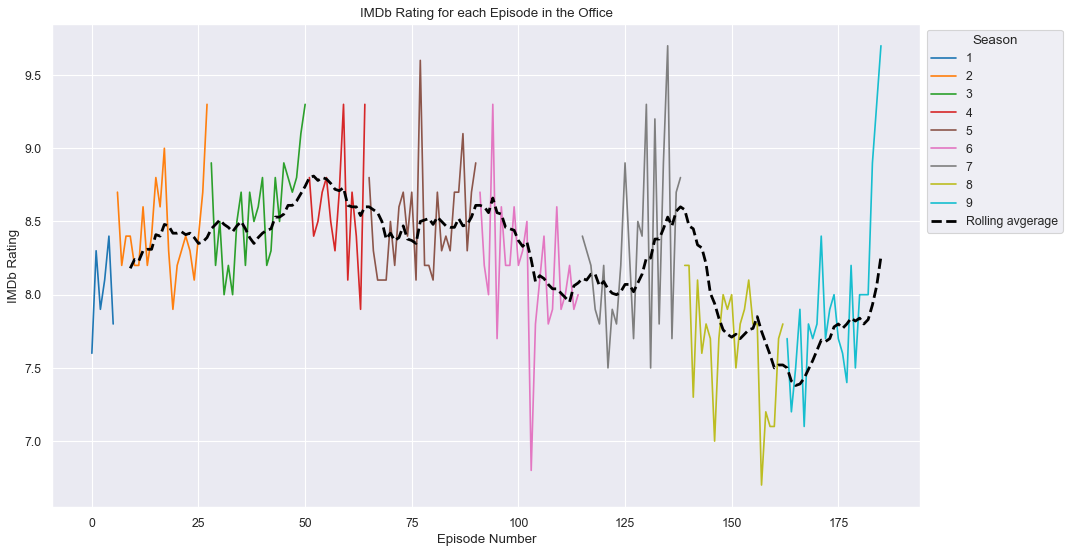

In [6]:
# Create a new DataFrame from data which includes an index column, this corresponds to episode number.
data_indexed = data.reset_index() 

# Plot ratings of each season
ax = sns.lineplot(data = data_indexed, x = 'index', y = 'imdb_rating', hue = 'season', palette= cmap, legend = 'full')

# Calculate and plot rolling average onto existing figure
data_indexed[ '10ep_rolling_avg' ] = data_indexed.imdb_rating.rolling(10).mean()
sns.lineplot( x = 'index', y = '10ep_rolling_avg', data = data_indexed, label = 'Rolling avgerage', linestyle='dashed', color = 'black', linewidth = 2.5)

# Axis setup
ax.legend(title = 'Season')

# Legend
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Plot Formatting
plt.title('IMDb Rating for each Episode in the Office')
plt.xlabel('Episode Number')
plt.ylabel('IMDb Rating')
plt.show()



Although this figure does not provide the most in-depth insights into each episode, it does allow us an overview of the general trend in IMDB rating as the show progressed as well as hightlighting potential outliers in the dataset. 

In regard to overall trend, consulting the rolling average of the previous 10 episodes, we can clearly see the show experienced a slow and steady increase in ratings throughout the first three seasons. This is most likely due to the show finding its feet and developing its own identity. The shows ratings appear relatively stable throughout the next 4 seasons except a small dip towards the end of season 6 and continuing into the beginning of season 7. It is season 8 where the show experienced its biggest decline in ratings, this could be due to many factors, such as the show losing creativity in writing/ directing or a shake-up in the cast members. Interestingly, the shows ratings increased into the final season, and continued on an upward trajectory thorughout the season, perhaps due to nostalgia. Other trends we can see from the figure is importance of the season finale. Note that in seasons 2,3,4 and 9, the season finale appears to be the highest rated episode in the season. This could be due to the payoff of several theme and character arcs from the season.

An interesting outlier is the lowest rated episode in season 6. Although this is not the overall lowest rated episode, it is clearly the episode which deviates (negatively) from it's season average the most. Another outlier is the final episode of the entire series, which is the (joint) highest rated episode of the series. This is likely due to it being the finale, rounding off the show. 

### 2.2 Data Cleaning

We choose not to remove the above outlier episodes as they may give some indication into what features gives a particularly good or bad episode - for example, the character 'Michael' returns in the final episode of the series, which may have been a contributing factor the spike in rating. 

At this point it is important to remember the brief of our task 'to advise what NBC Universal should do to produce the highest rated reunion episode possible'. We will not include the following features:
- 'season' and 'episode'. A special reunion episode will not fit into the standard seasons format.
- 'air_date'. The reunion episode will air significantly after the official finale in 2013. 
- 'episode_name'. These are unique strings and will be dictated by episode content. 
- 'total_votes'. This may be a good indicator of how well an episode is doing, but it is not a factor we can control. 

In [7]:
# Drop irrelevant columns
data = data.drop(columns=['season', 'episode', 'episode_name', 'air_date', 'total_votes'])

### 2.3 Correlation 

In this section we will examine the correlation between our numeric features.

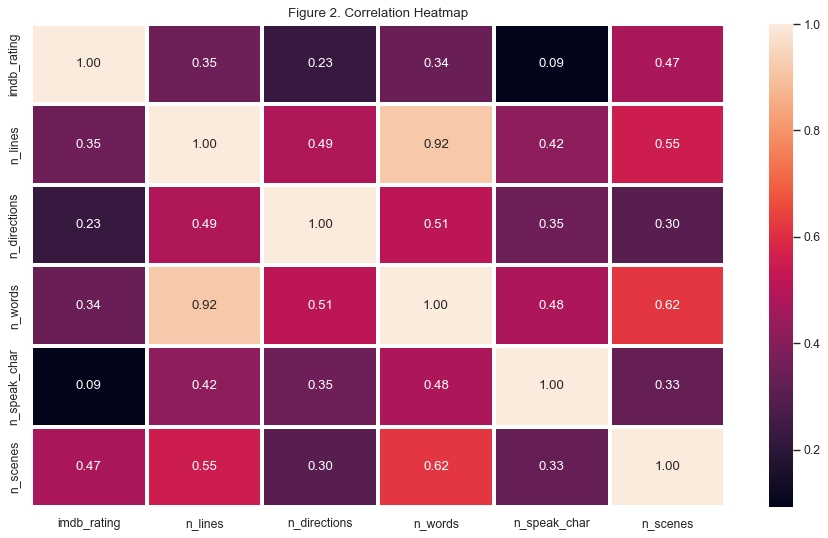

In [8]:
# Correlation heatmap 
sns.heatmap(data.corr(), annot = True, fmt = '.2f', linewidths = 2)
plt.title("Figure 2. Correlation Heatmap")
plt.show()

From Figure 2 we can see that all features are positively correlated with every other feature. The strongest correlation is between 'n_words' and 'n_lines' which suggests that the number of words per line is consistent throughout the series and we only really need one of these features in our model. <span style="color:red"> DO WE EVER DROP THIS FEATURE ??</span> The features most highly correlated with 'imbd_rating' are 'n_lines' and 'n_words'. The correlation between features is something we will keep in mind when developing our model.

### 2.4 Diagnostic Plots

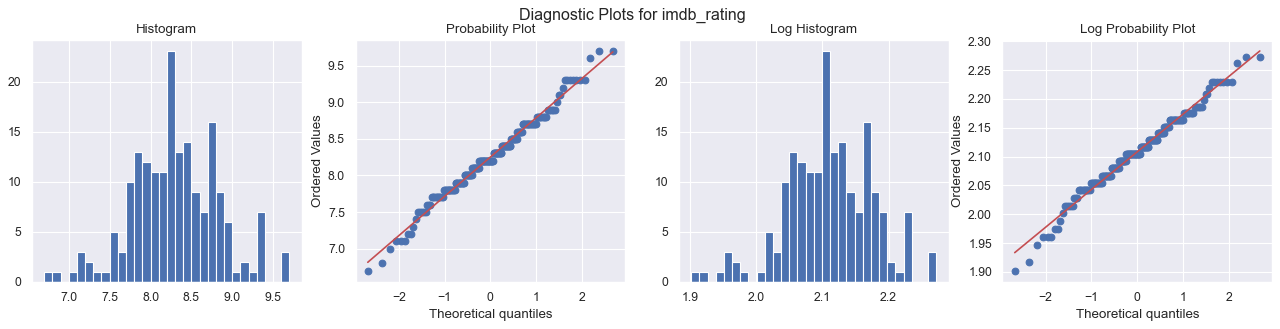

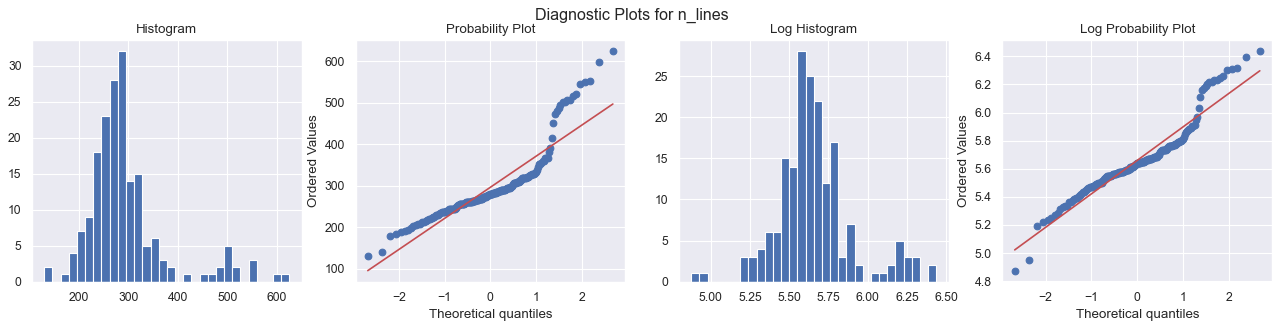

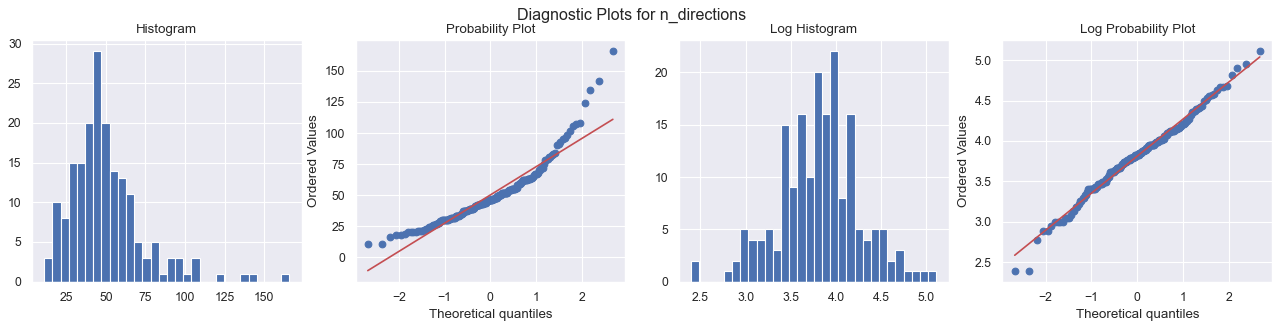

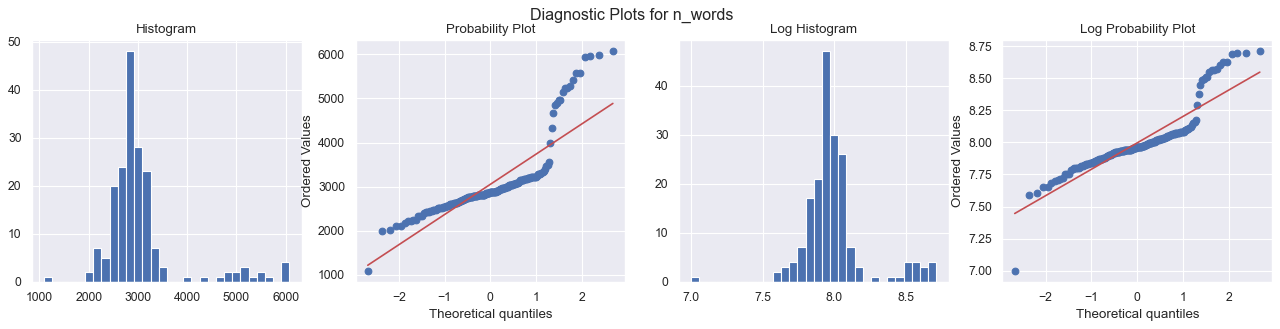

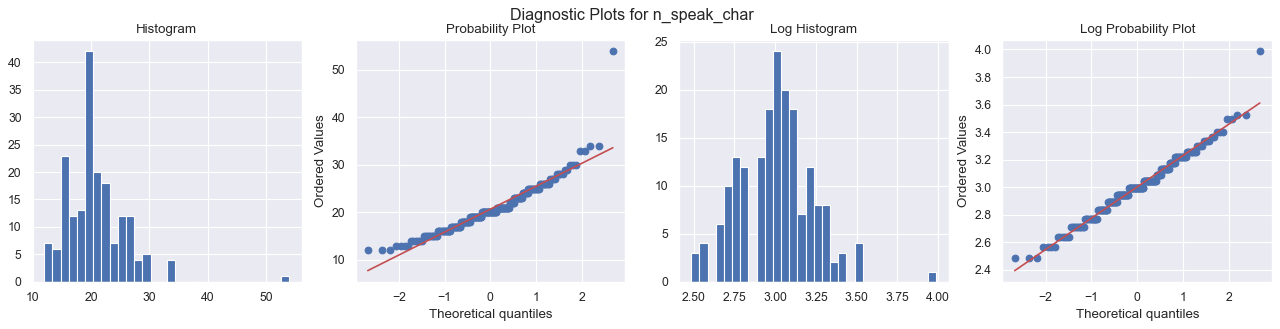

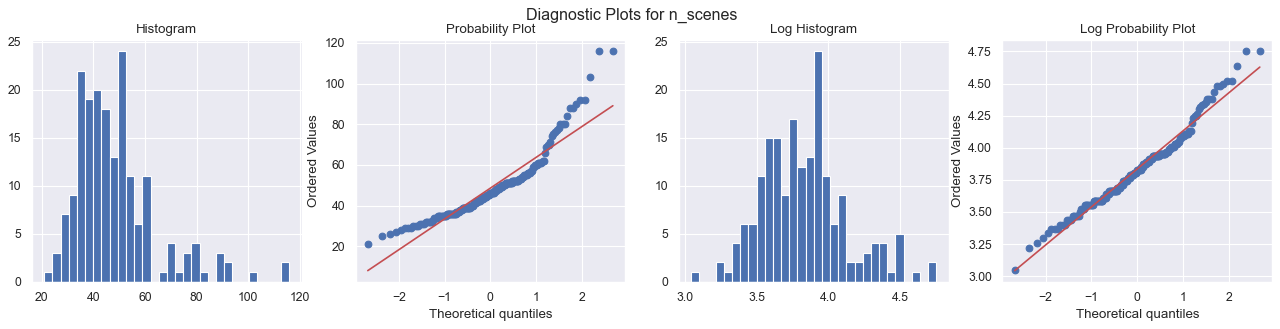

In [9]:
def diagnostic_plots(df, variable): 
    """
        Distributions of variable in dataframe - from Python Feature Engineering Cookbook.
        Outputs histogram, probability plot, log histogram, and log probability plot of variable distribution. 
    """

    plt.figure(figsize=(20,4)) 

    # Histogram
    plt.subplot(1, 4, 1) 
    df[variable].hist(bins=30)
    plt.title("Histogram")

    # Probability Plot
    plt.subplot(1, 4, 2)
    stats.probplot(df[variable], dist="norm", plot=plt) 

    # Log Histogram
    plt.subplot(1, 4, 3) 
    np.log(data[variable_name]).hist(bins=30)
    plt.title("Log Histogram")

    # Log Probability Plot
    plt.subplot(1, 4, 4)
    stats.probplot(np.log(data[variable_name]), dist="norm", plot=plt) 
    plt.title("Log Probability Plot")

    plt.suptitle("Diagnostic Plots for {}".format(variable))
    plt.show()

# run the diagnostic plots for all the features we are interested in 
for variable_name in data.select_dtypes(exclude = 'object'): # excludes columns with data type object, i.e. only investigate numeric values
    diagnostic_plots(data, variable_name)

The histogram and QQ-plot for 'imdb_rating' suggest that the ratings are normally distributed. For 'n_lines' we see that the distribution is heavily skewed to the left - we tackle this by considering the logarthim of the variable, which appears to shift the distribution. Note, the histogram and QQ-plot of 'log(n_lines)' look like a normal distribution. Similarly, 'n_directions', 'n_words' and 'n_speak_char' are all closer to normally distributed when logged. Therefore, we would expect to use logged values in our analysis...

In [10]:
# log data to make it normal - SHOULD CHECK TO SEE IF THIS ACTUALLY DOES ANYTHING!!
# Also quite badly written - very easy to log the values multiple times :(
# ^ skill issue, should be fixed now :)

try:
    has_data_been_logged == False
except:
    data['n_scenes'] = np.log(data['n_scenes'])
    data['n_directions'] = np.log(data['n_directions'])
    has_data_been_logged = True

### 2.5 Feature Investigation: Categorical
In this subsection we will investigate the three remaining categorical variables seperately, starting with characters, then writers and finally directors. We will make use of the following 'split_names' function to help transform our raw features into more useful features.

In [11]:
def split_names(column, minimum = -np.inf, df=data):
    '''
    Split names in a specific column by `;` and ignore other puntuation. Drop people with less than or equal minimum episodes
    '''
    # Retrieve data 
    data_column = (df[column]).copy()
    
    # Remove punctuation
    for punc in [' ', '.', '-']:
        data_column = data_column.str.replace(punc,'')
    
    # Split semicolon
    data_column = data_column.str.split(';',expand=False)
    
    allpeople = [item for sublist in data_column.to_list() for item in sublist].copy() # all possible people
    peopleepisodes = {x: allpeople.count(x) for x in allpeople}.copy() # number of episodes corresponding to a person 
    
    new_data_column = [] # new data without people <= minimum
    for episode in data_column: # iterate over all data
        new_episode = []
        for contributor in episode: # iterate over episodes
            if peopleepisodes[contributor] > minimum: # if person has enough episodes, add to new data
                new_episode.append(contributor)
        if new_episode == []: # if no one has over minimum, then set label as other
            new_episode.append('Other') 
        new_data_column.append(new_episode)
    new_data_column = pd.Series(new_data_column)
    data_column = pd.get_dummies(new_data_column.apply(pd.Series).stack()).sum(level=0)

    return data_column.copy()

In [12]:
def boxplot(df1, output, xlabel = None, title = None):
    df2 = pd.merge(output, df1, left_index=True, right_index=True)
    plotting=[]
    for character in df1:
        condition = character + '==1'
        plotting.append(df2.query(condition)['imdb_rating'])
    plt.boxplot(plotting)
    plt.xticks(rotation = 315)
    plt.xticks(np.arange(1,len(df1.columns) + 1), df1.columns)
    plt.xlabel(xlabel)
    plt.ylabel('IMDb Rating')
    plt.title(title)
    plt.show()


#### Characters

In the characters section we will split the character strings into each character and then explore how characters effect the shows rating. We then combine our character DataFrame with the data frame counting how many lines each character has in each episode. We do this because it gives us a measure of how important that character was in that episode.

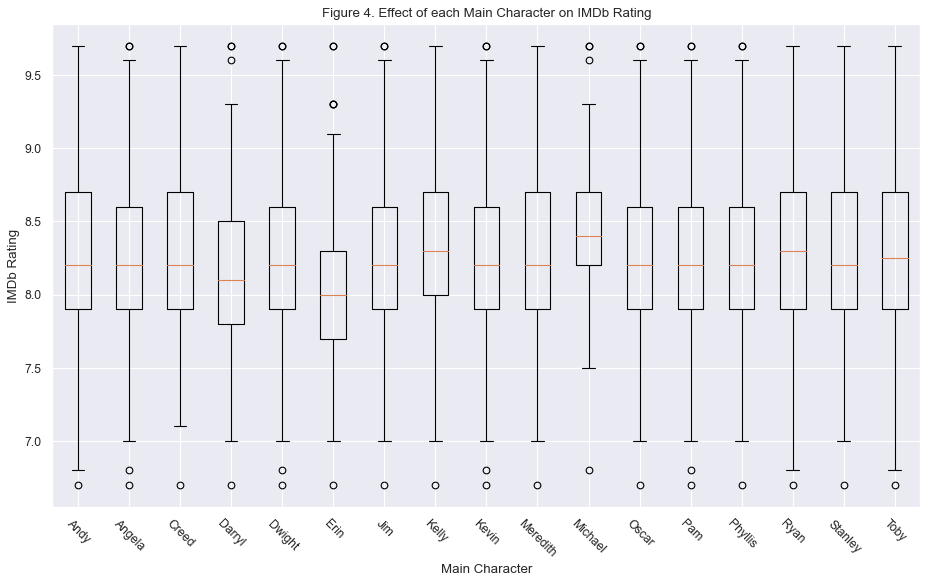

In [13]:
# Use split_names to create a feature for each main character
chars = split_names('main_chars')

# Merge IMDb rating into character DataFrame
chars2 = pd.merge(data['imdb_rating'], chars, left_index=True, right_index=True)

# Create a boxplot visualisng the effect on rating by each character
boxplot(chars, data['imdb_rating'], xlabel = 'Main Character', title = 'Figure 4. Effect of each Main Character on IMDb Rating')

Figure 3 shows that the character with the highest median episode rating is Michael and the character with the lowest is Erin. Other interesting observations about Micheal is that he is not only the character with the smallest inter-quartile range, but he also has smallest whiskers on his boxplot. These observations imply that Michael is consistently in high rating episodes and hence we would expect our model to incorporate him into the model. This is further emphaised in the next output which shows Michael in 4 of the 5 most highly rated episode, whilist only occurring in 1 of the 5 least highly rated episodes.

In [14]:
chars2.sort_values(by = ['imdb_rating'])

,imdb_rating,Andy,Angela,Creed,Darryl,Dwight,Erin,Jim,Kelly,Kevin,Meredith,Michael,Oscar,Pam,Phyllis,Ryan,Stanley,Toby
157,6.7,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1
103,6.8,1,1,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1
146,7.0,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,0
160,7.1,1,1,1,1,1,1,1,0,1,1,0,1,1,1,1,1,0
167,7.1,1,1,1,1,1,1,1,0,1,1,0,1,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,9.3,1,1,1,1,1,1,1,0,1,1,0,1,1,1,0,1,0
59,9.3,1,1,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0
77,9.6,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,0
135,9.7,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


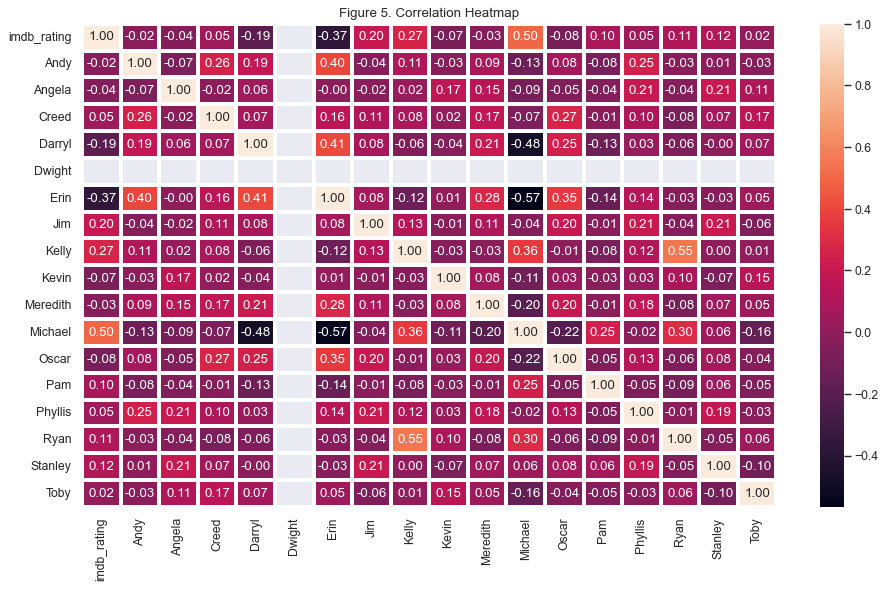

In [15]:
# Correlation - Why are we looking at correlation between features we will not ues? - Might ebe useful who knows?
sns.heatmap(chars2.corr(), annot = True, fmt = '.2f', linewidths = 2)
plt.title("Figure 5. Correlation Heatmap")
plt.show()

The correlation heatmap in Figure 4 shows that Michael is the charcter with greatest correlation with IMDb rating, which again reaffirms the importance of Michael to the fans and hence the ratings. Another thing of note in the figure is lack of any data Dwight, this is because Dwight appears in every single episode and hence there is zero variance in his appearance. This is importand because the formula to calculate correlation coefficient involves a division by variance. Thus dividing by zero gives us an error. Finally we note that most the characters aren't too strongly correlated with each other, with the obvious exceptions of Ryan and Kelly, positively, as well as Erin and Michael and Darryl and Michael, negatively. Therefore, we do not expect too many issues due to correlated features here.

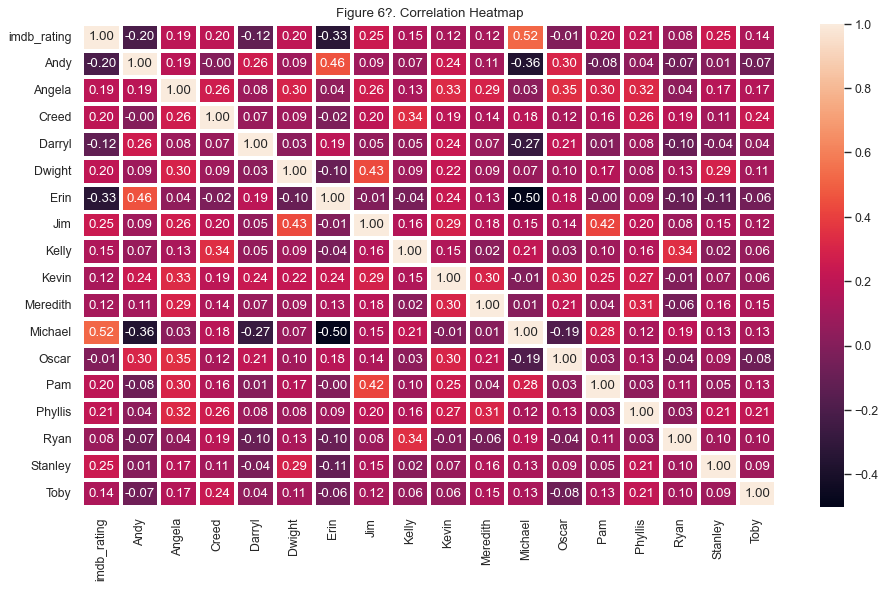

In [16]:
# Requires comments (William)?

reindex_df = pd.DataFrame(data_lines.groupby(['season', 'episode']).sum()).reset_index()

data_lines['total_episode']=0
for total_episode in reindex_df.index:
    s, e = reindex_df[['season','episode']].loc()[total_episode]
    index = [(data_lines['season']==s) & (data_lines['episode']==e)]
    data_lines['total_episode']=data_lines['total_episode']+(np.array(index)*total_episode)[0]


# Can this be adapted to use chars in it? Kinda feels like repeated code :(
main_chars = data['main_chars']
main_chars = main_chars.str.split(';')
main_chars = list(main_chars.apply(pd.Series).stack().unique())

n_lines_character = data_lines.groupby(['total_episode', 'speaker'])['n_lines'].sum()
n_lines_character = n_lines_character.reset_index()
n_lines_character = n_lines_character[n_lines_character['speaker'].isin(main_chars)]
n_lines_character = n_lines_character.reset_index()

n_lines_character = n_lines_character.pivot(index='total_episode',columns='speaker',values='n_lines').fillna(0)

sns.heatmap(pd.merge(data['imdb_rating'], n_lines_character, left_index=True, right_index=True).corr(), annot = True, fmt = '.2f', linewidths = 2)
plt.title("Figure 6?. Correlation Heatmap")
plt.show()

### 2.6 Feature Investigation: Writers

When exploring the writers and directers features, we will make use of the following split names function. In the writers feature there are a large number of writer who only wrote a very small number of episodes. These wroters may have an adverse effect on our model so we have decided to disregard any writer who wrote less than three episodes. Episodes written by a writer with fewer than 3 episodes will be recorded as being written by 'other'.

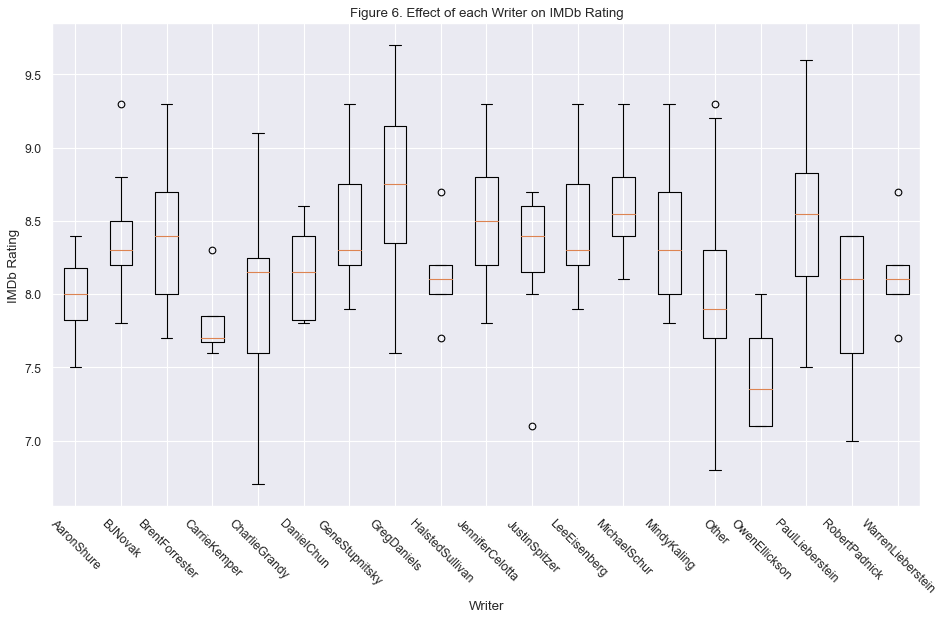

In [17]:
# Create a DataFrame of writers information.
writers = split_names('writer', minimum=3)

# Add Imdb rating to this DataFrame.
writers2 = pd.merge(data['imdb_rating'], writers, left_index=True, right_index=True)

# Create a boxplot visualisng the effect on rating by each write
boxplot(writers, data['imdb_rating'], xlabel = 'Writer', title = 'Figure 6. Effect of each Writer on IMDb Rating')

### 2.7 Feature Investigation: Directors

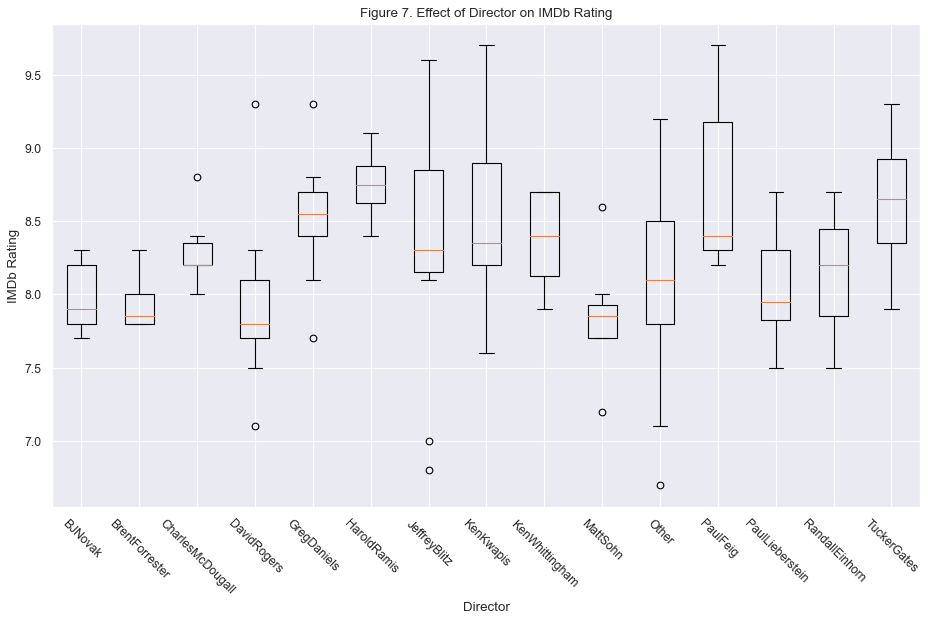

In [18]:
# Create a DataFrame of writers information.
direc = split_names('director', minimum=3)

# Add Imdb rating to this DataFrame.
direc2 = pd.merge(data['imdb_rating'], writers, left_index=True, right_index=True)

# Create a boxplot visualisng the effect on rating by each write
boxplot(direc, data['imdb_rating'], xlabel = 'Director', title = 'Figure 7. Effect of Director on IMDb Rating')

## 3. Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine and fit that model.*

- You are strongly encouraged to explore many different modeling methods (e.g. linear regression, regression trees, lasso, etc.) but you should not include a detailed narrative of all of these attempts. 
- At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validatin it.

*For example if you considered a linear regression model, a classification tree, and a lasso model and ultimately settled on the linear regression approach then you should mention that other two approaches were tried but do not include any of the code or any in depth discussion of these models beyond why they were rejected. This section should then detail is the development of the linear regression model in terms of features used, interactions considered, and any additional tuning and validation which ultimately led to your final model.* 

**This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.**

<span style="color:red">
I believe the plan is to use LASSO regression as it will perform feature selection which will improve interpretability.

'Ridge regression is useful when there is a concern about multicollinearity, and Lasso regression is useful when there are many predictors and some are suspected to be irrelevant or have little effect on the outcome.'

Should we use Cross-Validation to reduce variability in model fit and hence validation error?

A proposal for a general section plan:

    - Start with a simple general linear model with all the shit in it. We can use this as a baseline to show we are justified in making a more complicated model.
    - Make a LASSO model to get rid of un-necessary features
    - Maybe look into nonlinear or polynomial regression?

Other General things:

    - Should we consider named character in the main model, or should we instead, predict best number of characters and then try to find which characters they should be?
    - Should probably use the annoying SKlearn pipelines 
    - Comment code @Tristan Pang



Finally dont forget to 'regress the regression',

Your captian.

</span>

## 3. Model Fitting and Tuning

Now that we have a good idea about the structure of the data, we will split the data into train and test datasets, then try and fit it to different models. We will start with a simple linear model, which will allow us to gain more insight into the significance of our features, and give us a baseline to compare other models to. Since we have a lot of features, it would not be a suprise to run into overfitting issues when our model predicts the training data much better than the test data.

To remedy overfitting, we shall carefully select features (and possible higher order terms and interaction terms) using LASSO, which drops insignificant features of the train dataset. Once we fine-tune our features, then we can perform more complex and expensive regression in the hopes of finding a good model.

We shall first import the helper functions `get_coefs` and `model_fit` from Workshop 5 and setup our dataset. Thess will allow us to evaluate our model.

## Setup ⚙

In [19]:
def get_coefs(m):
    """Returns the model coefficients from a Scikit-learn model object as an array,
    includes the intercept if available.
    """
    # If pipeline, use the last step as the model
    if (isinstance(m, sklearn.pipeline.Pipeline)):
        m = m.steps[-1][1]
    if m.intercept_ is None:
        return m.coef_
    return np.concatenate([[m.intercept_], m.coef_])

def model_fit(m, X, y, plot = False):
    """Returns the mean squared error, root mean squared error and R^2 value of a fitted model based 
    on provided X and y values.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should fit plots be shown 
    """
    y_hat = m.predict(X)
    MSE = mean_squared_error(y, y_hat)
    RMSE = np.sqrt(mean_squared_error(y, y_hat))
    Rsqr = r2_score(y, y_hat)
    
    Metrics = (round(MSE, 4), round(RMSE, 4), round(Rsqr, 4))
    
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Actual vs Fitted plot")
        
        plt.subplot(122)
        sns.scatterplot(x='y_hat', y='resid', data=res).set_title("Fitted vs Residual plot")
        plt.hlines(y=0, xmin=np.min(y), xmax=np.max(y), linestyles='dashed', alpha=0.3, colors="black")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model (MSE, RMSE, Rsqr) = " + str(Metrics), fontsize=14)
        plt.show()
    
    return MSE, RMSE, Rsqr

In [20]:
from sklearn.metrics import r2_score
def print_r2(model, do_print=True):
    '''Takes a model and predicts the data using the test/train data and prints Rsquared value'''
    # Use the model to predict train and test data
    global y_train_pred, y_test_pred
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Rsquared
    test_r2 = r2_score(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    # Print Rsquared
    if do_print == True:
        print(r'Train R^2', train_r2)
        print(r'Test R^2', test_r2)
    else:
        return train_r2,test_r2

In [33]:
# Organise our features
people = n_lines_character.join(writers) # get list of writers
people = people.join(direc.add_suffix('_D')) # get list of directors

head = [ 'n_lines', 'n_directions', 'n_words', 'n_speak_char'] # Basic features
X_ = pd.merge(data[head], people, left_index=True, right_index=True) # All features
head = list(X_.keys()) # List of headers
X_ = X_.fillna(0) # NaN shenanigans

y = data['imdb_rating'] # Response variable

# Split dataset into 20% test and 80% train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size = 0.20, random_state=71)

In [25]:
# !!!TODO DELETE CELL
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV

# random seed selection
R2_list = []
i_list = []

for i in range(1,100):
    X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size = 0.20, random_state=i)
    
    elastic_model = make_pipeline(
        PolynomialFeatures(degree=2, include_bias=False, interaction_only=True), #Interaction terms
        StandardScaler(), # Scale features to normal
        ElasticNetCV(alphas=[0.0001, 0.01, 0.1, 0.25, 0.5, 0.75, 1, 5, 10, 100, 1000],cv=10)
        ).fit(X_train, y_train)

    
    
#     test_linear_model = LinearRegression()
#     test_linear_model.fit(X_train,y_train)
    
    i_list.append(i)
    R2_list.append(print_r2(elastic_model, False))
lol = pd.DataFrame(np.c_[i_list,R2_list])
lol.sort_values(by=2,ascending=False,axis=0).head(10)

# 35 for DecisionTreeRegressor


,0,1,2
70,71.0,0.507728,0.470761
72,73.0,0.524790,0.413793
34,35.0,0.529759,0.378546
1,2.0,0.565088,0.358183
12,13.0,0.547735,0.351546
60,61.0,0.555663,0.349605
95,96.0,0.554363,0.334069
64,65.0,0.564587,0.321013
20,21.0,0.551550,0.310912
30,31.0,0.547964,0.308901


## Linear Regression 📉

In [34]:
from sklearn.linear_model import LinearRegression

# Regress the regression 
test_linear_model = LinearRegression()
test_linear_model.fit(X_train,y_train)

# Rsquared
print_r2(test_linear_model)

# Coefficients of linear fit
coeffs = pd.DataFrame(test_linear_model.coef_, head, columns=['Coefficients'])
coeffs.sort_values(by='Coefficients',ascending=False).head(20)

Train R^2 0.46793856334403927
Test R^2 0.5259355004147633


,Coefficients
TuckerGates_D,0.510415
BrentForrester,0.316597
GregDaniels,0.299688
BJNovak,0.291077
CharlesMcDougall_D,0.290339
MindyKaling,0.243499
GregDaniels_D,0.215925
MichaelSchur,0.189950
PaulLieberstein,0.185776
Other,0.164656


We see that the model predicts the training data much better than the test data as expected. We see that writers and directors have the largest positive coefficients. This suggests that writers and directors have a greater impact on the model. The number of directions is also important. !!!TODO why?

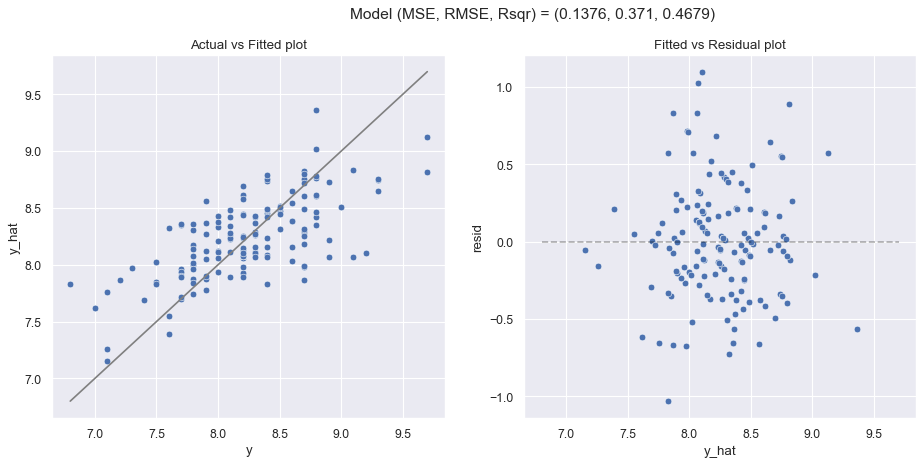

[ 7.37552645e+00 -1.71175536e-04 -4.87718195e-02  1.87272092e-05
  1.85023151e-02 -2.48942966e-03  6.06459285e-03  2.77191984e-03
  4.48193680e-03  1.49191810e-03  9.63491798e-04  3.96531424e-03
  4.44957472e-03 -6.18245860e-04 -6.03602685e-04  4.42554863e-03
 -3.24985414e-03 -2.63541385e-03  4.05796443e-03 -1.49063221e-03
  1.37840253e-02  2.75691894e-03 -9.72741291e-02  2.91077245e-01
  3.16596880e-01 -6.39157141e-02  1.49002077e-01  7.96385470e-02
  6.53095021e-02  2.99687757e-01  8.10957001e-02  1.46999977e-01
  1.52800591e-01  6.53095021e-02  1.89950309e-01  2.43498943e-01
  1.64656122e-01 -4.72954400e-01  1.85776482e-01 -9.79402406e-02
  8.10957001e-02 -1.15864290e-01 -4.01275899e-01  2.90339363e-01
  3.37458024e-02  2.15925065e-01 -1.03755989e-01 -3.65196703e-02
  2.45739308e-02 -1.07727855e-01 -1.46549856e-01 -3.73224507e-02
  1.43671906e-01 -1.15830963e-01 -1.53824265e-01  5.10415171e-01]


In [35]:
model_fit(test_linear_model, X_train, y_train, plot = True)
print(get_coefs(test_linear_model))

In the first model, the points in the actual vs fitted plot are much closer to the fitted line than the second mode, suggesting it is indeed better. For both residual plots the points seem to be equally distributed about 0, suggesting linearity assumption is indeed reasonable. Some points are quite far away from the 0 line suggesting the model struggles to deal with outliers, however this is slightly better in first plot. Finally R^2 value of first plot is better as well as MSE and RMSE.

## LASSO 🤠

We now perform Lasso with interaction terms.

In [36]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import PolynomialFeatures

# Create a pipeline that uses LASSO
lasso_model = make_pipeline(
    PolynomialFeatures(degree=3, include_bias=False, interaction_only=True), #Interaction terms
    StandardScaler(), # Scale features to normal
    LassoCV(alphas=[0.0001, 0.01, 0.1, 0.25, 0.5, 0.75, 1, 5, 10, 100, 1000])
    ).fit(X_train, y_train)

# R squared
print_r2(lasso_model)

coefs = lasso_model['lassocv'].coef_
feature_names = lasso_model[:-1].get_feature_names_out()
importance_ranking = sorted(zip(map(abs, coefs), feature_names), reverse=True)

for rank, (coef, feature) in enumerate(importance_ranking[:10]):
    print("Rank {}: {} ({})".format(rank+1, feature, coef))


# Most important coefficients
features_lasso = [x for x in feature_names[coefs != 0]]
print("Selected alpha:", lasso_model['lassocv'].alpha_)
print("Selected features:", features_lasso)


Train R^2 0.3072449847968044
Test R^2 0.2630821859053073
Rank 1: Michael (0.12150249144815099)
Rank 2: Andy Phyllis GregDaniels (0.03550184183700628)
Rank 3: n_directions Phyllis GregDaniels (0.02930269118682564)
Rank 4: Andy Angela Kevin (0.024615504265178837)
Rank 5: n_speak_char Jim Stanley (0.014590480830256464)
Rank 6: Creed Jim Kevin (0.014298361773903309)
Rank 7: Darryl Michael Other (0.012146891592694175)
Rank 8: Erin Oscar Other_D (0.009746063694485704)
Rank 9: OwenEllickson (0.006778794365269084)
Rank 10: Darryl Stanley OwenEllickson (0.004653112920086866)
Selected alpha: 0.1
Selected features: ['Michael', 'OwenEllickson', 'n_directions Phyllis GregDaniels', 'n_speak_char Jim Stanley', 'Andy Angela Kevin', 'Andy Phyllis GregDaniels', 'Creed Jim Kevin', 'Darryl Michael Other', 'Darryl Stanley OwenEllickson', 'Erin Oscar Other_D']


TODO why does this has a lower train R^2

!!!TODO explain why michel important etc. Cite something, or many things

Although LASSO gives us a very low R^2 score, the train and test R^2 are much closer which suggests more consistent modelling. We also get a list of important features which gives us insight into features we shall keep.

We see that the characters Michael, Scranton Strangler and Stanley are the most important for the show's success. This is because...

n_words important, why? (`plt.hist(X_['n_words'])`)

The director Ken Kwapis wrote the Finale episode, which was the highest rated show...

## ElasticNet 🥅

In [37]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures

# Create a pipeline that uses ElasticNetCV
elastic_model = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False, interaction_only=True), #Interaction terms
    StandardScaler(), # Scale features to normal
    ElasticNetCV(alphas=[0.0001, 0.01, 0.1, 0.25, 0.5, 0.75, 1, 5, 10, 100, 1000],cv=10)
    ).fit(X_train, y_train)

# R squared
print_r2(elastic_model)

coefs = elastic_model['elasticnetcv'].coef_
feature_names = elastic_model[:-1].get_feature_names_out()
importance_ranking = sorted(zip(map(abs, coefs), feature_names), reverse=True)

for rank, (coef, feature) in enumerate(importance_ranking[:10]):
    print("Rank {}: {} ({})".format(rank+1, feature, coef))


# Most important coefficients
features_elastic = [x for x in feature_names[coefs != 0]]
print("Selected alpha:", elastic_model['elasticnetcv'].alpha_)
print("Selected features:", features_elastic)


Train R^2 0.5077279692190134
Test R^2 0.4707610239283051
Rank 1: Michael (0.11155383032743071)
Rank 2: Phyllis GregDaniels (0.06615639504689592)
Rank 3: Angela BrentForrester (0.038231375660066035)
Rank 4: Erin Other (0.02573533757447681)
Rank 5: n_speak_char Michael (0.0256094812593567)
Rank 6: RobertPadnick JeffreyBlitz_D (0.02469763538090061)
Rank 7: Erin TuckerGates_D (0.024183856382070358)
Rank 8: BJNovak TuckerGates_D (0.02411275943069674)
Rank 9: Erin GregDaniels (0.023712238134332937)
Rank 10: Andy OwenEllickson (0.02317719125929005)
Selected alpha: 0.1
Selected features: ['Michael', 'OwenEllickson', 'n_lines OwenEllickson', 'n_directions Michael', 'n_words Phyllis', 'n_words OwenEllickson', 'n_speak_char Jim', 'n_speak_char Michael', 'Andy Angela', 'Andy Ryan', 'Andy GeneStupnitsky', 'Andy LeeEisenberg', 'Andy OwenEllickson', 'Andy KenKwapis_D', 'Angela Darryl', 'Angela AaronShure', 'Angela BrentForrester', 'Angela DavidRogers_D', 'Angela JeffreyBlitz_D', 'Darryl PaulLieberste

ElasticNet is an alternative model that improves on LASSO. There is an obvious improvent in R^2 score. There are also more features that are important.

## better models, maybe not

!!!TODO

Additionally, we used ..... [models tried but not included] .... These all yielded similar, but slight less effective results than [model]. This is expected as [some models tried] work by ...

In [38]:
#!!!todo delet
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoLars
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import TweedieRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import RidgeCV



# List of models
models_list = [
    LinearRegression(), 
    LassoCV(), 
    LassoLars(),
    ElasticNetCV(),
    RidgeCV(),
    OrthogonalMatchingPursuit(), 
    BayesianRidge() , 
    ARDRegression(),
    TweedieRegressor(),
    DecisionTreeRegressor(), #overfitting
    KNeighborsRegressor()
]

for model in models_list:
    # regress the regression 
    print(model)
    model = make_pipeline(
        #PolynomialFeatures(degree=2, include_bias=False, interaction_only=True),
        #RFECV(LinearRegression(), step=1, cv=len(X_train_)-1),
        #LeaveOneOut(),
        StandardScaler(),
        model
        ).fit(X_train, y_train)

    # use the regressed regression to predict
    print_r2(model)
# coefficients of regression
# print(model.named_steps['linearregression'].intercept_)
# coeffs = pd.DataFrame(model.named_steps['linearregression'].coef_,columns=['Coefficients'])
# coeffs = pd.DataFrame(model.named_steps['linearregression'].coef_, head, columns=['Coefficients'])
# coeffs


LinearRegression()
Train R^2 0.467809315523784
Test R^2 0.5287517462399307
LassoCV()
Train R^2 0.2925781759998485
Test R^2 0.4004433656311027
LassoLars()
Train R^2 0.0
Test R^2 -0.005402113772867034
ElasticNetCV()
Train R^2 0.2890235257056175
Test R^2 0.39444811631588106
RidgeCV(alphas=array([ 0.1,  1. , 10. ]))
Train R^2 0.4636132832449603
Test R^2 0.5315066652981963
OrthogonalMatchingPursuit()
Train R^2 0.32293302429996606
Test R^2 0.4349503098829738
BayesianRidge()
Train R^2 0.37396684779879386
Test R^2 0.4904606052567321
ARDRegression()
Train R^2 0.4017120411828732
Test R^2 0.4691434496828687
TweedieRegressor()
Train R^2 0.39529764882338525
Test R^2 0.5109622288589304
DecisionTreeRegressor()
Train R^2 1.0
Test R^2 0.40929104142330874
KNeighborsRegressor()
Train R^2 0.39944482395242564
Test R^2 0.40672333542995764


## Final model 🏁

We now run our final model.

In [101]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures

# Create a pipeline that uses ElasticNetCV
final_model = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False, interaction_only=True), #Interaction terms
    StandardScaler(), # Scale features to normal
    ElasticNetCV(alphas=[0.1],cv=10)
    ).fit(X_train, y_train)

# R squared
print_r2(final_model)

coefs = final_model['elasticnetcv'].coef_
feature_names = final_model[:-1].get_feature_names_out()
importance_ranking = sorted(zip(map(abs, coefs), feature_names), reverse=True)

for rank, (coef, feature) in enumerate(importance_ranking[:10]):
    print("Rank {}: {} ({})".format(rank+1, feature, coef))


# Most important coefficients
features_elastic = [x for x in feature_names[coefs != 0]]
print("Selected alpha:", final_model['elasticnetcv'].alpha_)
print("Selected features:", features_elastic)


Train R^2 0.5077279692190134
Test R^2 0.4707610239283051
Rank 1: Michael (0.11155383032743071)
Rank 2: Phyllis GregDaniels (0.06615639504689592)
Rank 3: Angela BrentForrester (0.038231375660066035)
Rank 4: Erin Other (0.02573533757447681)
Rank 5: n_speak_char Michael (0.0256094812593567)
Rank 6: RobertPadnick JeffreyBlitz_D (0.02469763538090061)
Rank 7: Erin TuckerGates_D (0.024183856382070358)
Rank 8: BJNovak TuckerGates_D (0.02411275943069674)
Rank 9: Erin GregDaniels (0.023712238134332937)
Rank 10: Andy OwenEllickson (0.02317719125929005)
Selected alpha: 0.1
Selected features: ['Michael', 'OwenEllickson', 'n_lines OwenEllickson', 'n_directions Michael', 'n_words Phyllis', 'n_words OwenEllickson', 'n_speak_char Jim', 'n_speak_char Michael', 'Andy Angela', 'Andy Ryan', 'Andy GeneStupnitsky', 'Andy LeeEisenberg', 'Andy OwenEllickson', 'Andy KenKwapis_D', 'Angela Darryl', 'Angela AaronShure', 'Angela BrentForrester', 'Angela DavidRogers_D', 'Angela JeffreyBlitz_D', 'Darryl PaulLieberste

In [104]:
get_coefs(final_model)

array([8.24121622, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ])

In [108]:
final_model[-1].intercept_

8.241216216216214

In [117]:
X_train.keys()

55

In [146]:
# Define ideal episode
ideal_episode = {'n_lines':0, 'Michael':0}
ideal_episode = dict(X_test.loc[77])
ideal_episode['Michael']=300

ideal_episode.update({key: (ideal_episode[key] if key in ideal_episode.keys() else 0)for key in head}) # Pad ungiven values with 0
ideal_episode.update({key: [value] for key, value in ideal_episode.items()}) # Put all elements in a list
ideal_episode = pd.DataFrame.from_dict(ideal_episode) # Convert to pd dataframe



final_model.predict(ideal_episode)

array([9.32595455])

Tristan's todo:

- ROC does not work on nonbinary
- get dir, writer etc for result and get imdb
- comment

TODO Compare graph to ref....

ROC curve


The Office is a common dataset in literature. In [2], they used a variety of different models, including Stochastic Gradient Descent and K Neigbours and got an R^2 of around 0.4.

Explain why hard to predict....



## 4. Discussion and Conclusions


*In this section you should provide a general overview of **your final model**, its **performance**, and **reliability**.* 

- You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant.

- This should be written with a target audience of a NBC Universal executive who is with the show and university level mathematics but not necessarily someone who has taken a postgraduate statistical modeling course. 

- Your goal should be to convince this audience that your model is both accurate and useful.

- Finally, you should include concrete recommendations on what NBC Universal should do to make their reunion episode a popular as possible.

**Keep in mind that a negative result, i.e. a model that does not work well predictively, but that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explanations / justifications.**

## 5. References

[1] Ralhan, A. (2018, May) *The Office lines*. https://data.world/abhinavr8/the-office-scripts-dataset. Accessed 28/02/2023.

[2] Akula, R., Wieselthier, Z., Martin, L., & Garibay, I. (2019, April). *Forecasting the Success of Television Series using Machine Learning*. In 2019 SoutheastCon (pp. 1-8). IEEE.

stackexchange

chatGPT

Tristan Pang
